# Intuit and Implement: Batch Normalization

In this notebook I will go over the intuition and implementaion of Ioffe and Svegedy's batch normalization.




## An Intuitive Explanation of Batch Normalization

### The Problem

Problem 1.  As the network trains, the inputs of each neuron varies wildly. As a result, each neuron must readjust itself to the varying distribution of each new batch. This is an inefficiency that only serves to slow model training. How can we regularize unit inputs?

Another effect of the variatied input distribution is <a href="http://neuralnetworksanddeeplearning.com/chap5.html#the_vanishing_gradient_problem">vanishing gradients</a>. The vanishing gradient problem is a big deal, particularly for the sigmoid activation function. If $g(x)$ represents the sigmoid activation function, as $| x |$ increases, $g^\prime(x)$ tends to zero.



<h6 class="text-center">Sigmoid Function and its Derivative</h6> 
<div class="align-center">
<img src="https://cdn-images-1.medium.com/max/1500/0*K5rfrS3lIXmDh6p6." height=300 width=500>
    </div>


Problem 2.    When input distribution varies, so does neuron output. This results in neuron outputs that fluctuate into the sigmoid function's saturable regions. Once there neurons can neither update their own weights, nor pass a gradient back to prior layers. How can we keep neuron outputs from varying into saturable regions?

<br>
<h6 class="text-center">The Sigmoid Sweet Spot</h6> 
<div class="align-center pr-30 mr-30">
<img src="img/sweet.png" height=300 width=500>
    </div>



### Batch Norm as a Solution.

Batch normalization mitigates the effects of a varying input distribution. By standardizing LINK the output of neurons, we restrain variation towards saturable regions. This solves our second problem.

<br>

<img src="img/sig4.png" height=800 width=800>

<br>


Batch normalization transforms neuron outputs into a unit gaussian distribution. When fed through the sigmoid funtion, layer outputs will also become more normal. As layer outputs are also layer inputs, neuron inputs will now have less variation. This solves our first problem.

### Mathematical Explanation

With batch normalization we seek a zero-centered, unit variance distribution of inputs for our activation function. During training time we take an activation input $x_i$ and subtract it by the batch mean $\mu_{B}$
to achieve a zero centered distribution.

<br>
<div class="text-center">
$\hat{x} = x_i-\mu_{B}$
 </div>

<br>



Next we take $x$ and divide it by the batch variance and a small number to prevent division by zero $\sigma_{B}+\epsilon$. This ensures that all activation input distributions have unit variance.

<br>
<div class="text-center">
$\hat{x} = \frac{x_i-\mu_{B}}{\sigma_{B}+\epsilon}$
</div>
<br>

Lastly we put $\hat{x}$ through a linear transformation to scale and shift the output of batch normalization $y_i$. Ensuring that this normalizing effect is maintained despite the changes in the network during back propagation. 

<br>
<div class="text-center">
$y_i=\lambda *\hat{x_i}+\beta$
</div>
<br>




During test time we do not use batch mean or variance, as this would break the model. (Hint: What is the mean and variance of a single observation?) Instead, we calculate a moving average and variance estimate of the training population. These estimates are averages of all batch means and variances calculated during training. 






### Benefits of Batch Normalization


The benefits of batch normalization are the following.





#### 1. Helps prevent vanishing gradient in networks with saturable nonlinearities (sigmoid, tanh, etc)



With Batch normalization we ensure that the inputs of any activation function do not vary into saturable regions. Batch norm transforms the distribution of those inputs to be unit gaussian (zero-centered and unit variance). Tjis limits the effect of vanishing gradients.

#### 2. Regularizes the model

Maybe. Ioffe and Svegeddy make this claim but doesn't right extensively on the issue. Perhaps this comes as a result of normalizing layer inputs?



#### 3.  Allows for Higher Learning Rates

By preventing issues with vanishing gradient during training, we can afford to set higher learning rates. Batch normalization also reduces dependence on parameter scale. Large learning rates can increase the scale of layer parameters which cause the gradients to amplify as they are passed back during back propagation. I need to read more about this.


# Implementation in Keras

### Imports

In [1]:
import tensorflow as tf 
import numpy as np
import os

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Model, Sequential
from keras.layers import Input

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D, Dense
from keras.layers import MaxPooling2D, Dropout, Flatten

import time

Using TensorFlow backend.


### Data Load and Preprocessing


In this notebook we use the Cifar 100 toy dataset, as it is reasonably challenging, and won't take forever to train. The only preprocessing performed is a zero-centering, and a image variation generator.

In [2]:
from keras.datasets import cifar100
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

#scale and regularize the dataset
x_train = (x_train-np.mean(x_train))
x_test = (x_test - x_test.mean())

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#onehot encode the target classes
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)


train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train,
                                     y = y_train,
                                    batch_size=80,)

### Constructing the Model in Keras

Convolutional blocks composed of 2 stacked 3x3 convolutions followed by a max pool and dropout. There are 5 convolutional blocks in each network. The final layer is a fully connected layer with 100 nodes and softmax activation. 

We will be constructing 4 different networks, each with either sigmoid or ReLU activations and either with batch normalization or without. We will compare the time to convergence and validation loss of each of the networks to its colleagues.

In [3]:
def conv_block_first(model, bn=True, activation="sigmoid"):
    """
    The first convolutional block in each architecture. Only seperate so we can 
    specify the input shape.
    """
    model.add(Conv2D(60,3, padding = "same", input_shape = x_train.shape[1:]))
    if bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(MaxPooling2D())
    model.add(Dropout(0.15))
    return model

def conv_block(model, bn=True, activation = "sigmoid"):
    """
    Generic convolutional block with 2 stacked 3x3 convolutions, max pooling, dropout, 
    and an optional Batch Normalization.
    """
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(MaxPooling2D())
    model.add(Dropout(0.15))
    return model

def conv_block_final(model, bn=True, activation = "sigmoid"):
    """
    I bumped up the number of filters in the final block. I made this seperate so that
    I might be able to integrate Global Average Pooling later on. 
    """
    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(Flatten())
    return model

def fn_block(model):
    """
    I'm not going for a very deep fully connected block, mainly so I can save on memory.
    """
    model.add(Dense(100, activation = "softmax"))
    return model

def build_model(blocks=3, bn=True, activation = "sigmoid"):
    """
    Builds a sequential network based on the specified parameters.
    
    blocks: number of convolutional blocks in the network, must be greater than 2.
    bn: whether to include batch normalization or not.
    activation: activation function to use throughout the network.
    """
    model = Sequential()
    
    model = conv_block_first(model, bn=bn, activation=activation)
    
    for block in range(1,blocks-1):
        model = conv_block(model, bn=bn, activation = activation)
        
    model = conv_block_final(model, bn=bn, activation=activation)
    model = fn_block(model)
    
    return model

def compile_model(model, optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]): 
    """
    Compiles a neural network.
    
    model: the network to be compiled.
    optimizer: the optimizer to use.
    loss: the loss to use.
    metrics: a list of keras metrics.
    """
    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics = metrics)
    return model

In [4]:
sigmoid_without_bn = build_model(blocks = 5, bn=False, activation = "sigmoid")
sigmoid_without_bn = compile_model(sigmoid_without_bn)

sigmoid_with_bn = build_model(blocks = 5, bn=True, activation = "sigmoid")
sigmoid_with_bn = compile_model(sigmoid_with_bn)


relu_without_bn = build_model(blocks = 5, bn=False, activation = "relu")
relu_without_bn = compile_model(relu_without_bn)

relu_with_bn = build_model(blocks = 5, bn=True, activation = "relu")
relu_with_bn = compile_model(relu_with_bn)

### Model Training



#### Sigmoid without Batch Normalization



In [5]:
start = time.time()
model_checkpoint = ModelCheckpoint('models/sigmoid_without_bn.h5',
                                   save_best_only = True)

history1 = sigmoid_without_bn.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=20,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  18.215039443969726  minutes


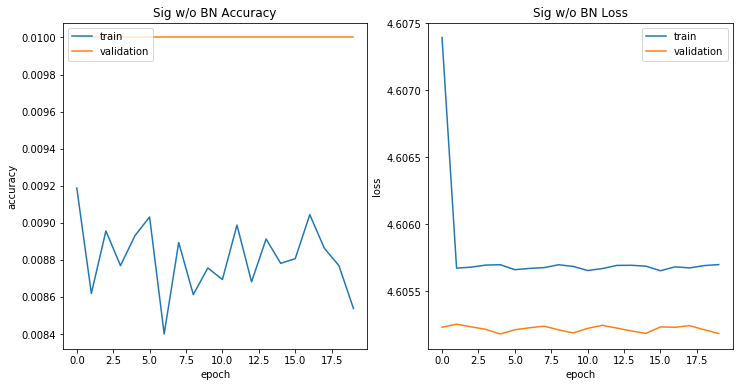

In [6]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Sig w/o BN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Sig w/o BN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Sigmoid with Batch Normalization

In [7]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/sigmoid_with_bn.h5',
                                   save_best_only = True)

history2 = sigmoid_with_bn.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  21.079602988560996  minutes


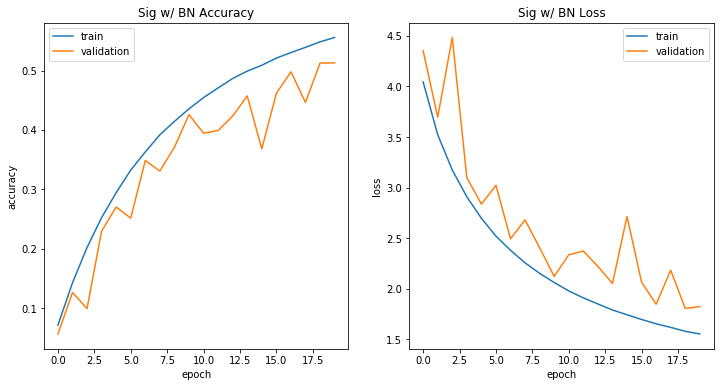

In [8]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Sig w/ BN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Sig w/ BN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### ReLU Without Batch Normalization

In [9]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/ReLU_without_BN.h5',
                                   save_best_only = True)

history3 = relu_without_bn.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=20,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  17.91213236252467  minutes


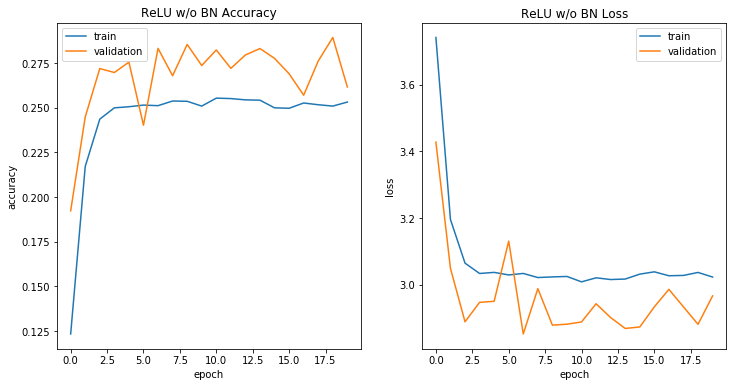

In [10]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('ReLU w/o BN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('ReLU w/o BN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### ReLU with Batch Normalization

In [11]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/ReLU_with_bn.h5',
                                   save_best_only = True)

history4 = relu_with_bn.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  20.0256649017334  minutes


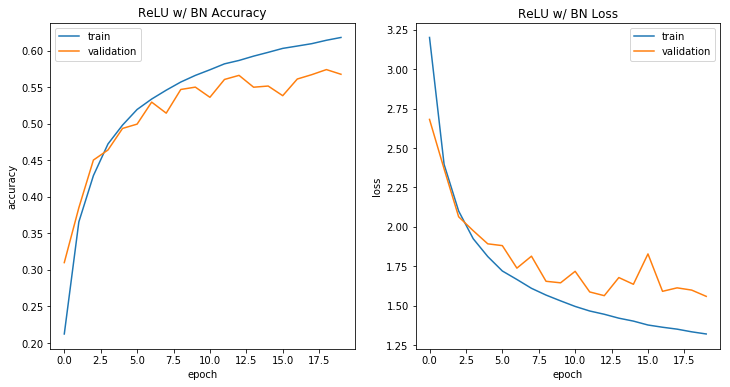

In [12]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('ReLU w/ BN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('ReLU w/ BN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Comparing Architectures


We clearly see the benefit of batch normalization here. Both ReLU and sigmoid models w/o batch normalizations failed to maintain performance gains. This may be a result of vanishing gradient.  Architectures with batch normalization trained faster and performed better than architectures without batch normalization.

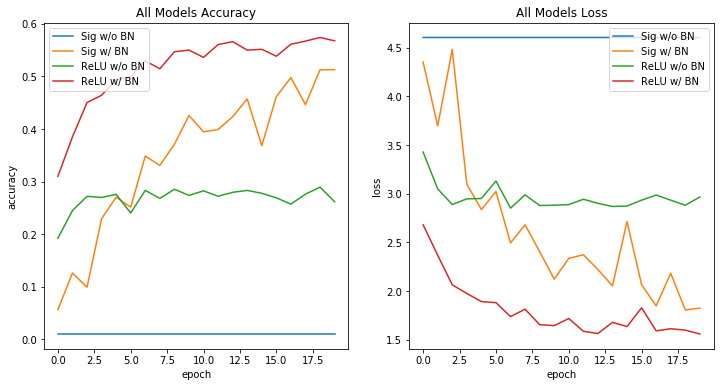

In [13]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history1.history['val_acc'])
plt.plot(history2.history['val_acc'])
plt.plot(history3.history['val_acc'])
plt.plot(history4.history['val_acc'])
plt.title('All Models Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Sig w/o BN', 'Sig w/ BN', 'ReLU w/o BN', 'ReLU w/ BN'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.title('All Models Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Sig w/o BN', 'Sig w/ BN', 'ReLU w/o BN', 'ReLU w/ BN'], loc='upper right')
plt.show()


## Conclusion

Batch normalization reduced training time and boost stability of a neural network. This effect applies to both the sigmoid and ReLU activation functions. In my next notebook I will be summarizing the effects of global average pooling to the training of convolutional neural networks.


### Resources

- Original paper by Ioffe and Szegedy. <a href="https://arxiv.org/abs/1502.03167"> here. </a>

- Insert a batch normalization before or after nonlinearities?
<a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture6.pdf"> Usage explanation </a>

- For an explanation of the math and implementation in TensorFlow. <a href="https://towardsdatascience.com/pitfalls-of-batch-norm-in-tensorflow-and-sanity-checks-for-training-networks-e86c207548c8"> Pitfalls of Batch Norm</a>

- Also this post <a href="https://towardsdatascience.com/how-to-use-batch-normalization-with-tensorflow-and-tf-keras-to-train-deep-neural-networks-faster-60ba4d054b73">How to use Batch Normalization with TensorFlow and tf.keras</a>

### Further reading

Below are some more recent research papers that extend Ioffe and Svegedy's work.

<a href="https://arxiv.org/abs/1702.03275v2">[1]</a> How Does Batch Normalization Help Optimization? (No, It Is Not About Internal Covariate Shift)



<a href="https://arxiv.org/abs/1702.03275v2">[2]</a> Batch Renormalization: Towards Reducing Minibatch Dependence in Batch-Normalized Models 



<a href="https://arxiv.org/abs/1607.06450v1">[3]</a> Layer Normalization



<a href="https://arxiv.org/abs/1602.07868v3">[4]</a> Weight Normalization: A Simple Reparameterization to Accelerate Training of Deep Neural Networks



<a href="https://arxiv.org/abs/1803.08494v3">[5]</a> Group Normalization

